## Sample test simulation

This notebook contains the basic syntax required to run a chain. We set up a mock data object from a test sim, construct an emulator and likelihood object, and pass these to a sampler to run for a small number of steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["savefig.dpi"] = 140
mpl.rcParams["figure.dpi"] = 140
import numpy as np
import time

# our own modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_gadget
from cup1d.data import data_nyx
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import emcee_sampler


def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [2]:

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)


DEBUG:jupyter_black:Using config from /home/jchaves/Proyectos/projects/lya/cup1d/pyproject.toml
DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

### Read archive

In [27]:
# specify simulation suite and P1D mesurements
drop_sim = True
# test_sim_label = "mpg_central"
test_sim_label = "mpg_5"
igm_sim_label = "mpg_central"

if test_sim_label[:3] == "nyx":
    training_set = "Nyx23_Oct2023"
    emulator_label = "Nyx_v0"
    archive = nyx_archive.NyxArchive(verbose=True)
elif test_sim_label[:3] == "mpg":
    training_set = "Cabayol23"
    emulator_label = "Cabayol23"
    archive = gadget_archive.GadgetArchive(postproc="Cabayol23")

### Set emu

In [4]:
if test_sim_label[:3] == "nyx":
    if is_number(test_sim_label[-1]) & drop_sim:
        emu_path = (
            "NNmodels/Nyx23_Oct2023/Nyx_v0_drop_sim_" + test_sim_label + ".pt"
        )
        drop_sim_val = test_sim_label
    else:
        emu_path = "NNmodels/Nyx23_Oct2023/Nyx_v0.pt"
        drop_sim_val = None
elif test_sim_label[:3] == "mpg":
    if is_number(test_sim_label[-1]) & drop_sim:
        emu_path = (
            "NNmodels/Cabayol23/Cabayol23_drop_sim_" + test_sim_label + ".pt"
        )
        drop_sim_val = test_sim_label
    else:
        emu_path = "NNmodels/Cabayol23/Cabayol23.pt"
        drop_sim_val = None

In [5]:
emulator = nn_emulator.NNEmulator(
    training_set=training_set,
    emulator_label=emulator_label,
    emu_params=["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "kF_Mpc"],
    model_path=emu_path,
    drop_sim=drop_sim_val,
    train=False,
)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


In [6]:
# setup mock data from sim
z_max = 4.5
data_label = "Chabanier2019"
if test_sim_label[:3] == "nyx":
    data = data_nyx.Nyx_P1D(
        archive=archive,
        sim_label=test_sim_label,
        z_max=z_max,
        data_cov_label=data_label,
        polyfit_kmax_Mpc=emulator.kmax_Mpc,
        polyfit_ndeg=emulator.ndeg,
    )
else:
    data = data_gadget.Gadget_P1D(
        archive=archive,
        sim_label=test_sim_label,
        z_max=z_max,
        data_cov_label=data_label,
        polyfit_kmax_Mpc=emulator.kmax_Mpc,
        polyfit_ndeg=emulator.ndeg,
    )

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [28]:
# stick to primordial power-law parameters here
free_param_names = ["As", "ns"]
# specify the number of free parameters per IGM function (default=2, but it would take forever here)
n_igm = 1
for i in range(n_igm):
    for par in ["tau", "sigT_kms", "gamma", "kF"]:
        free_param_names.append("ln_{}_{}".format(par, i))
free_param_names

['As', 'ns', 'ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0']

In [29]:
theory = lya_theory.Theory(
    zs=data.z,
    emulator=emulator,
    free_param_names=free_param_names,
    sim_igm=igm_sim_label,
)

In [30]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms = None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor = 0
like = likelihood.Likelihood(
    data=data,
    theory=theory,
    free_param_names=free_param_names,
    prior_Gauss_rms=prior_Gauss_rms,
    emu_cov_factor=emu_cov_factor,
)

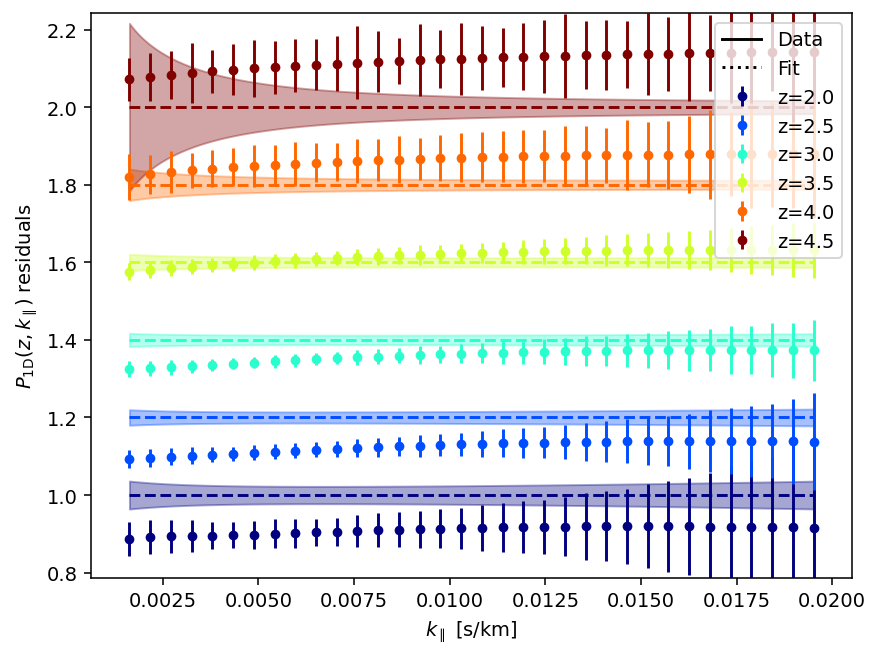

In [31]:
like.plot_p1d(residuals=True, plot_every_iz=2)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [32]:
import os

In [33]:
# Set up sampler
rootdir = os.path.dirname(os.environ["LACE_REPO"]) + "/data/cup1d/sampler/"
sampler = emcee_sampler.EmceeSampler(like=like, progress=True, rootdir=rootdir)

Created directory: /home/jchaves/Proyectos/projects/lya/data/cup1d/sampler//chain_1
setup with 240 walkers


In [34]:
n_steps = 1000
n_steps = 100
if data_label == "Chabanier2019":
    if n_igm == 0:
        n_burn_in = 75
    else:
        n_burn_in = 250
elif data_label == "QMLE_Ohio":
    if n_igm == 0:
        # TBD (need to check)
        n_burn_in = 200
    else:
        n_burn_in = 1200

In [35]:
for p in like.free_params:
    print(p.name, p.value, p.min_value, p.max_value)

As 2.1e-09 7.4e-10 4.11e-09
ns 0.965 0.68 1.32
ln_tau_0 0.0 -0.4 0.4
ln_sigT_kms_0 0.0 -2.0 2.0
ln_gamma_0 0.0 -0.6 0.6
ln_kF_0 0.0 -0.8 0.8


100%|█████████████████████████████████████████| 350/350 [01:36<00:00,  3.63it/s]

-138.88760506291533
Sampling took 96.9 seconds


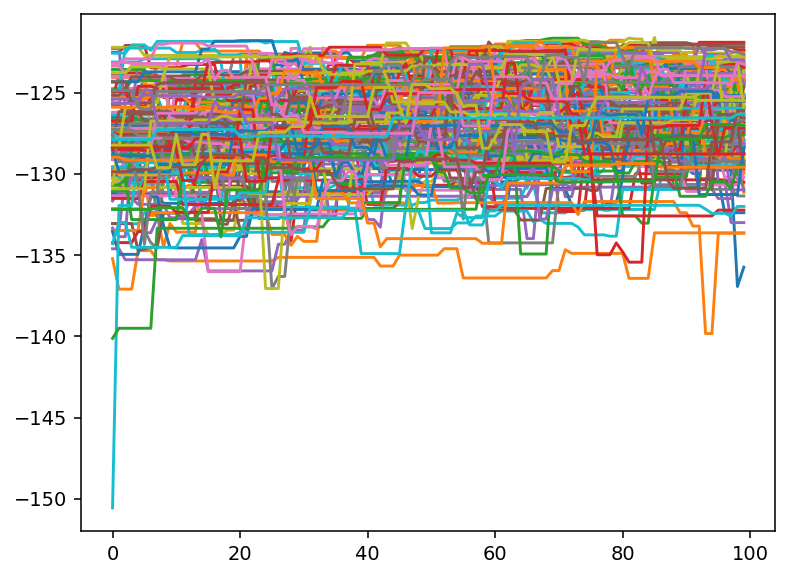

In [36]:
start = time.time()
emcee_out = sampler.run_sampler(n_burn_in, n_steps, parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

Mean values: [0.08624710547849548, 0.5521386127969468, 0.639748313071268, 0.5231265758109152, 0.6231848054338659, 0.307884402867939]
Mean values: [0.08624710547849548, 0.5521386127969468, 0.639748313071268, 0.5231265758109152, 0.6231848054338659, 0.307884402867939]


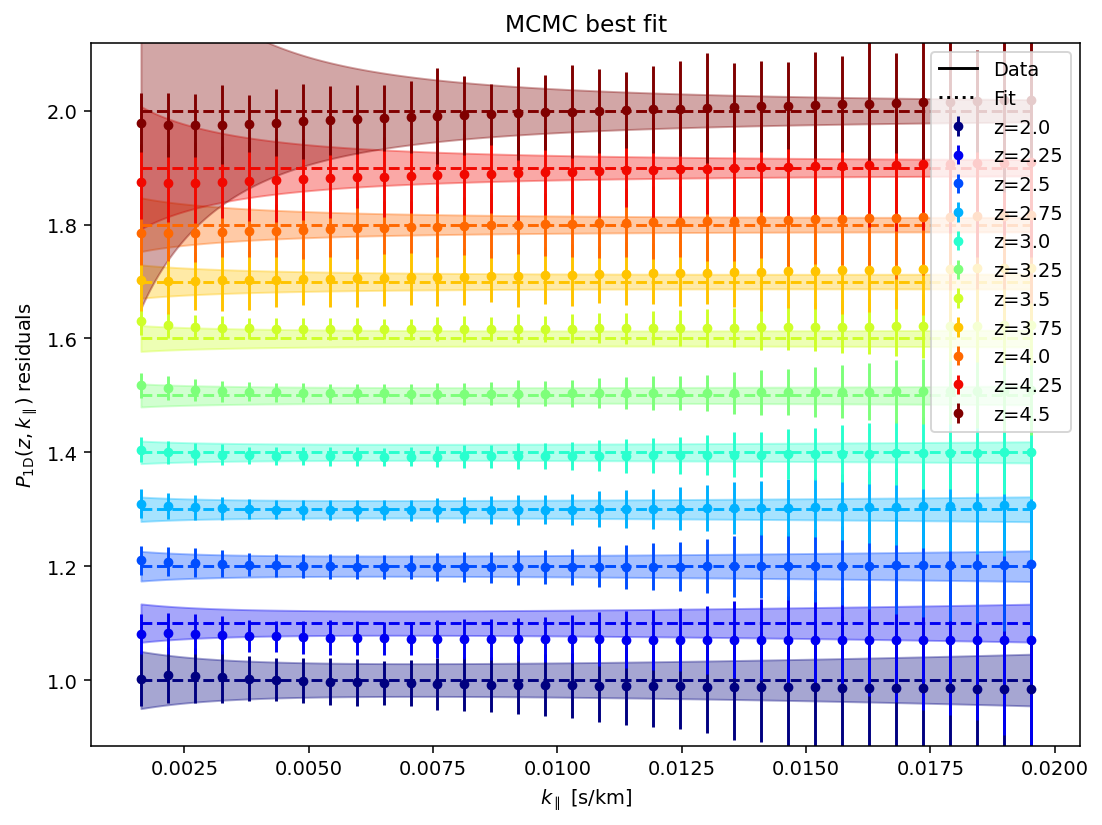

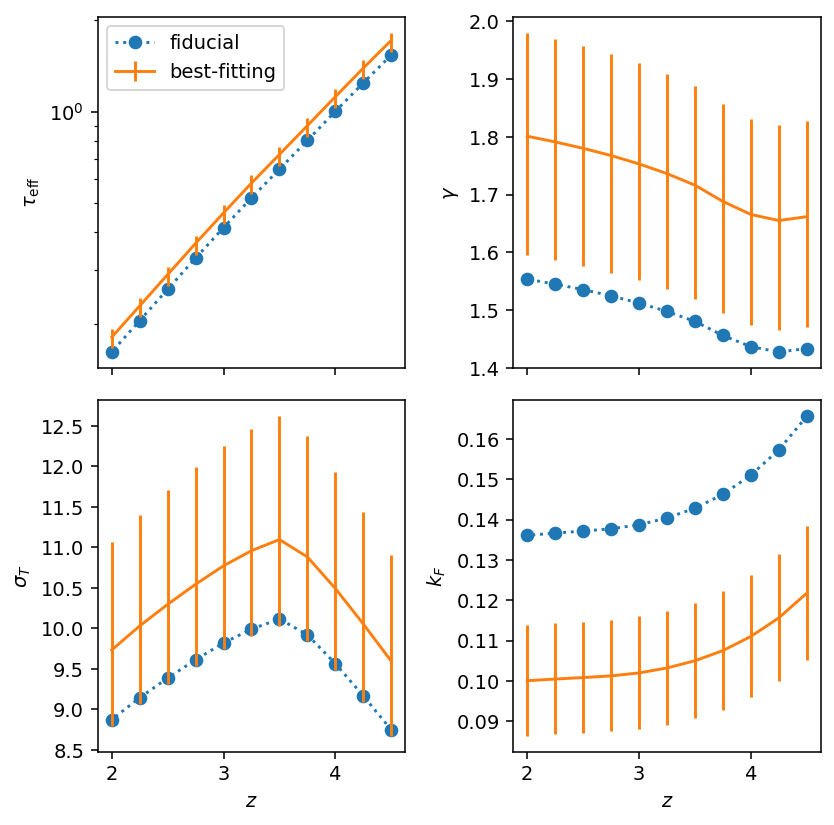

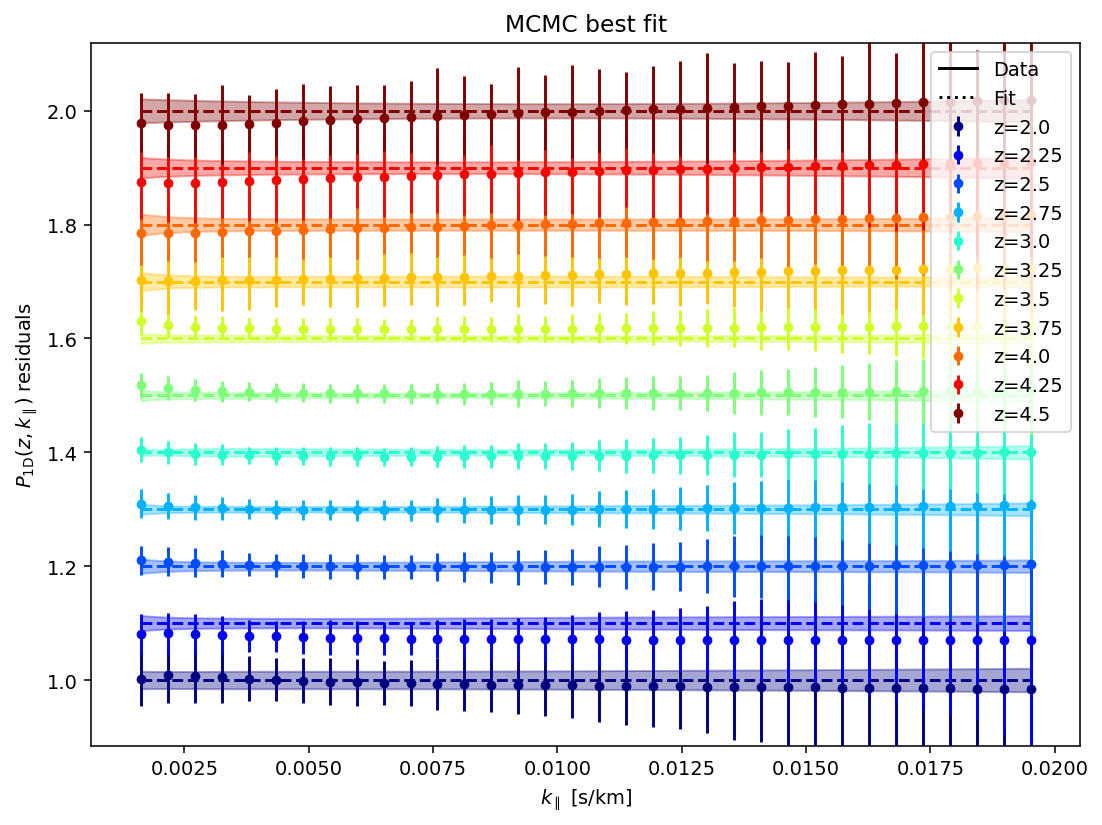

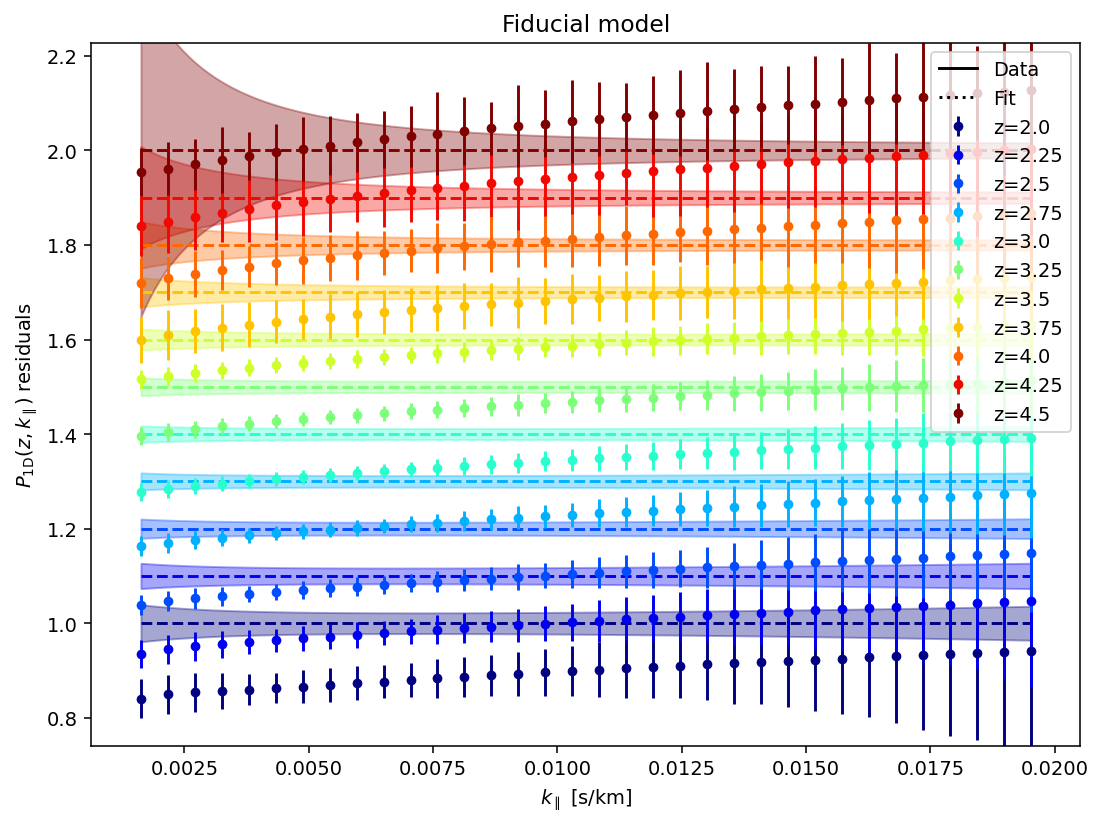

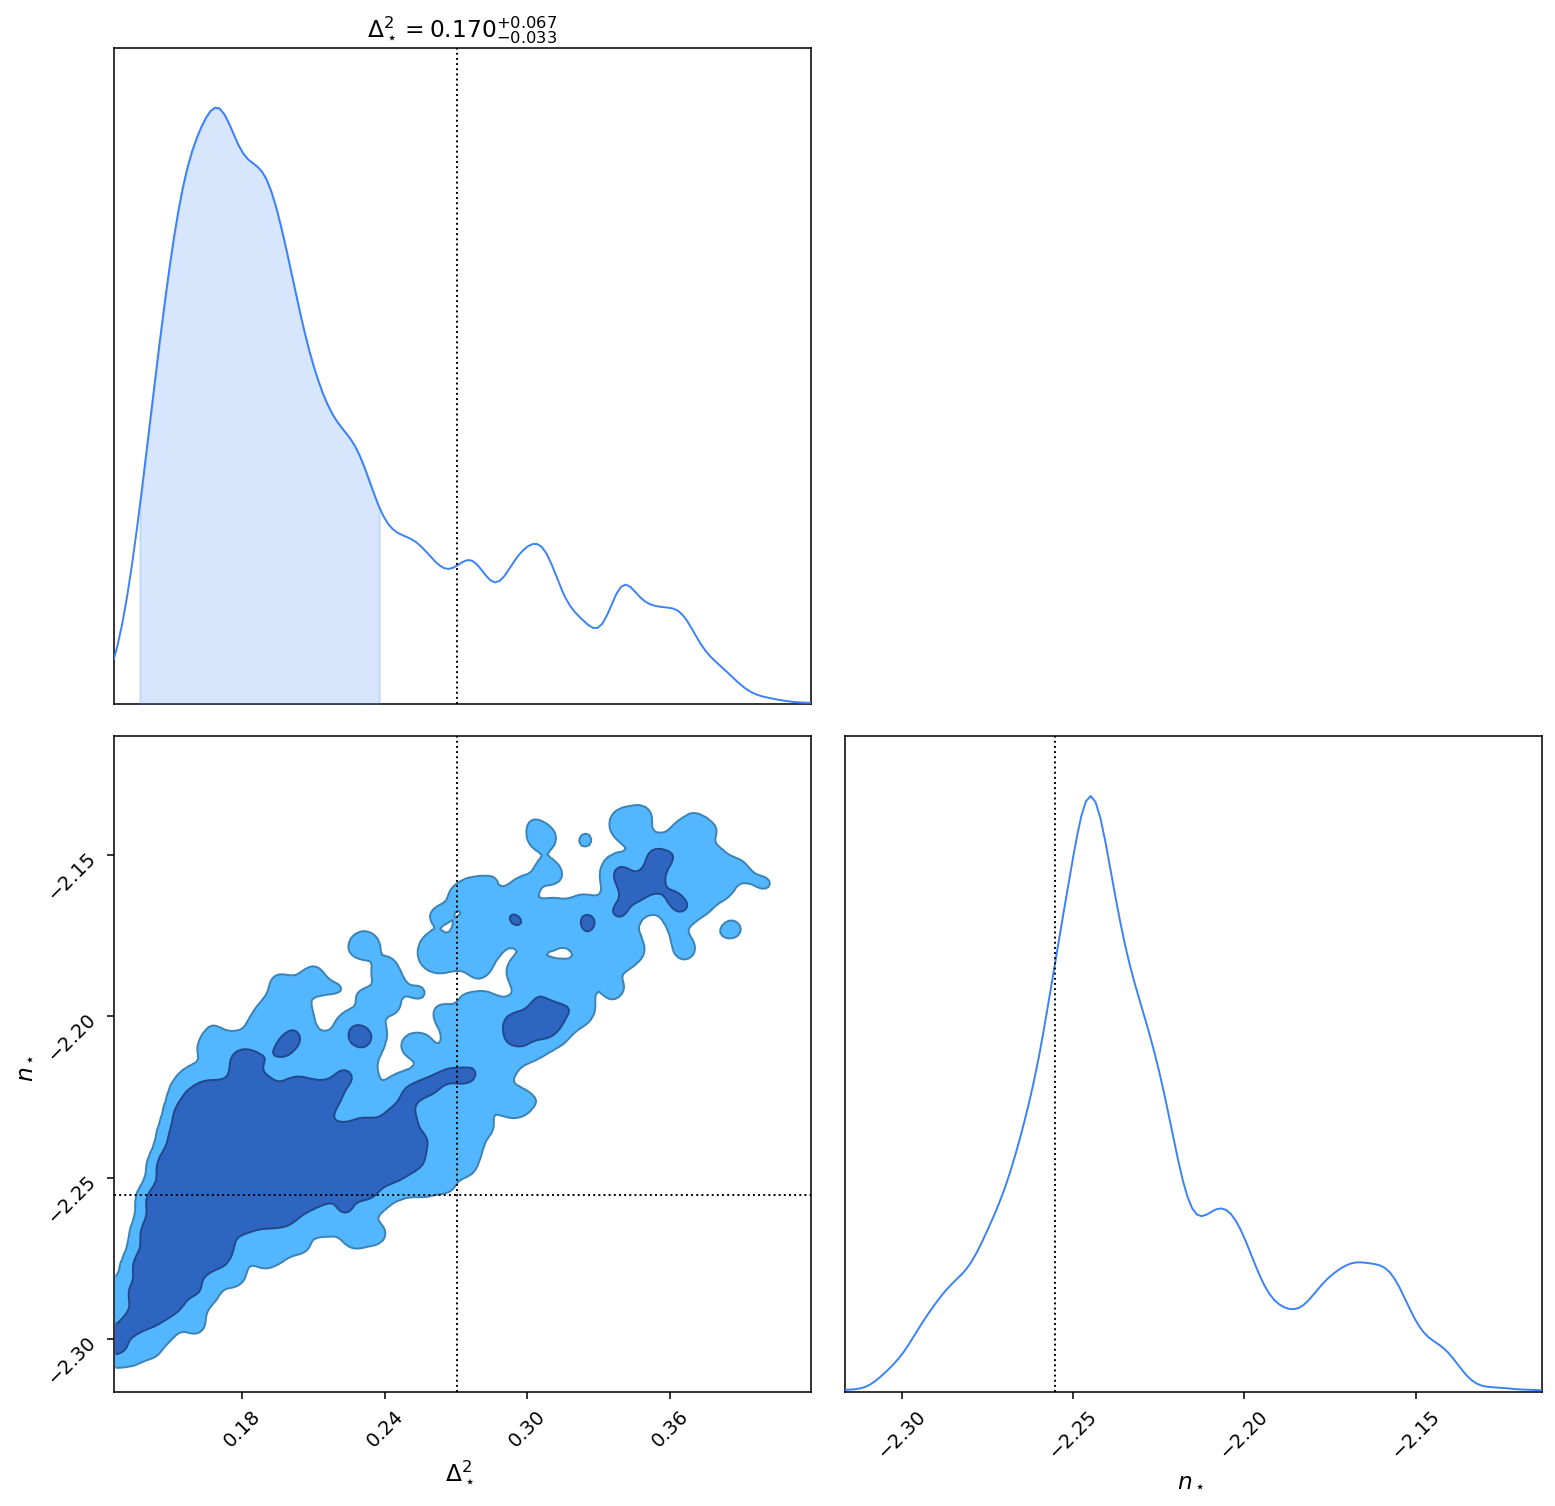

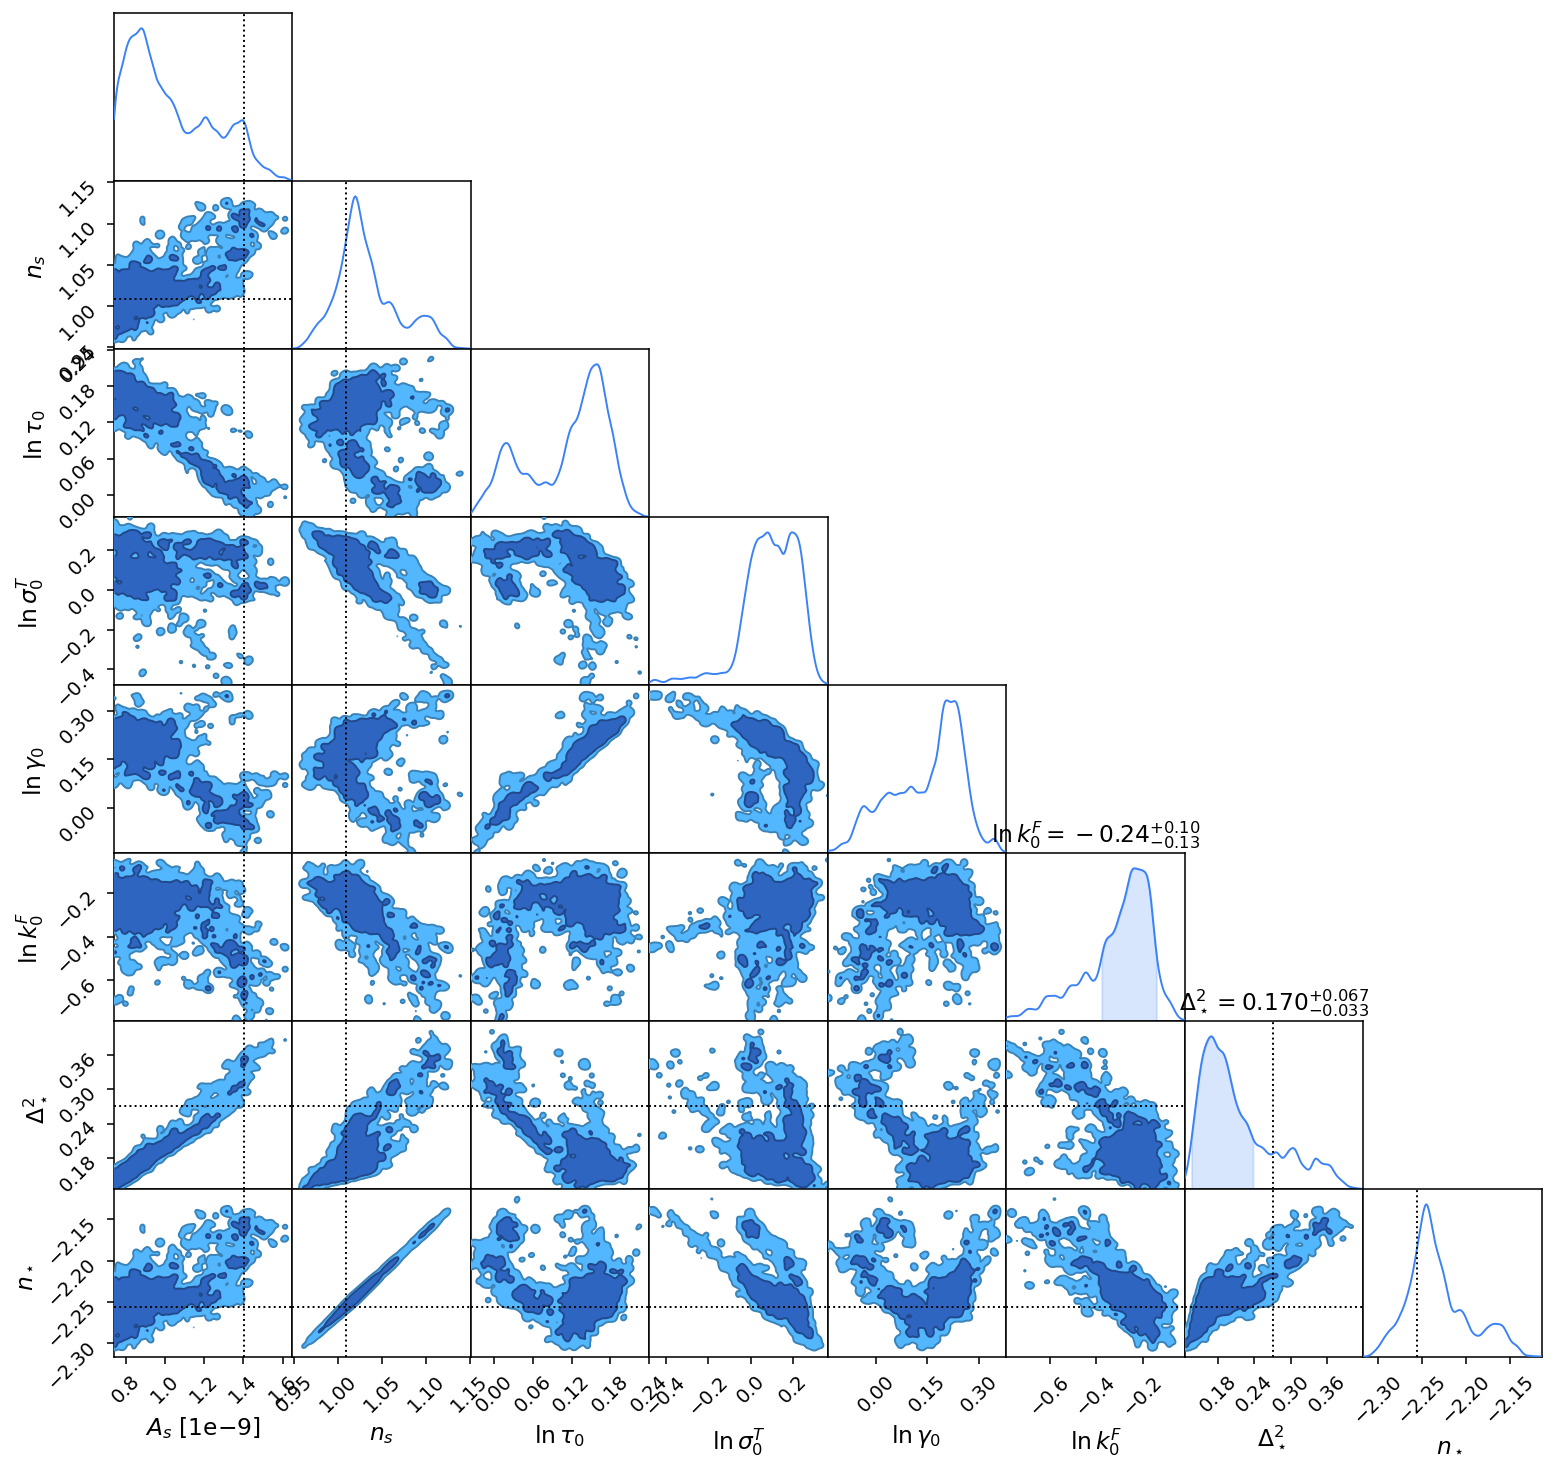

In [37]:
sampler.write_chain_to_file()